# Introduction

Key takeaways
* Installing packages
* Handling data with pandas
* Unzipping Files with Python
* Using seaborn for vizualization
* Using matplotlib for vizualization
* Creating Lambda functions
* Deploying machine learning models
* Evaluating machine learning results
* Validating aggregates

# The CRISP-DM Process

For this project, I will be following the CRISP-DM (Cross-industry standard process for data mining) process.

![alt text](https://codesachin.files.wordpress.com/2015/09/crisp-dm.gif)
The process follows these steps:
    1. Pick a dataset
    2. Generate business questions
    3. Obtain data understanding
    4. Prepare the data
    5. Analyze, Model, and Visualize
    6. Evaluate your analysis
    7. Communicate business insights   
 
 
    
This project approaches these steps in the following way:
    1. Boston & Seattle Airbnb Open Data 
    2. I am starting with these business questions.
        a. What is the mission of Airbnb?
        b. What is more likely to cause bad reviews?
        c. What is the cost of bad reviews?
        d. What is the value of good reviews?
    3. Steps 3 to 6 will be conducted using a Jupyter notebook, and some Python 3 magic!

# Data Handling

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
%matplotlib inline
plt.style.use('ggplot')

In [3]:
def unzip_files(zip_filename_list, folder=None):
    """
    Unzipping the datasets
    """
    folder_names = []
    for file in zip_filename_list:
        
        # paths
        filename_path = os.path.join('data', file)
        folder_name = filename_path[:-4].replace("-", "_")
        
        # extracting
        try:
            zip_ref = ZipFile(filename_path)
            zip_ref.extractall(folder_name)
            zip_ref.close()
        except:
            print('File already extracted!')
        
        # appending folder names
        if filename_path.find('.') >= 0:
            folder_names.append(folder_name)
        
    return folder_names

In [4]:
def read_concat(folder_names, target_file_name):
    """
    Reading files of different folders with same naming convention
    """
    df_con = pd.DataFrame()
    for folder in folder_names:
        target = os.path.join(folder, target_file_name)
        df = pd.read_csv(target)
        df['rowsource'] = target
        
        df_con = pd.concat([df_con, df], axis=0, sort=True).reset_index(drop=True)
    return df_con

## - Extracting Data

In [5]:
# getting zip file names
data_zip = os.listdir('data')
data_zip

['boston-airbnb-open-data.zip',
 'boston_airbnb_open_data',
 'seattle',
 'seattle.zip']

In [6]:
# extracting datasets
folder_names = unzip_files(data_zip)
folder_names

File already extracted!
File already extracted!


['data\\boston_airbnb_open_data', 'data\\seattle']

In [7]:
[os.listdir(folder_name) for folder_name in folder_names]

[['calendar.csv', 'listings.csv', 'reviews.csv'],
 ['calendar.csv', 'listings.csv', 'reviews.csv']]

## - Importing Data

---
First, we are importing the calendar dataset.

In [8]:
calendar = read_concat(folder_names, 'calendar.csv')

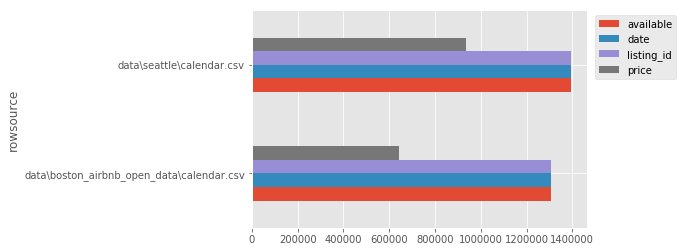

In [9]:
calendar.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');

---
Second, we are importing the listings dataset.

In [10]:
listings = read_concat(folder_names, 'listings.csv')

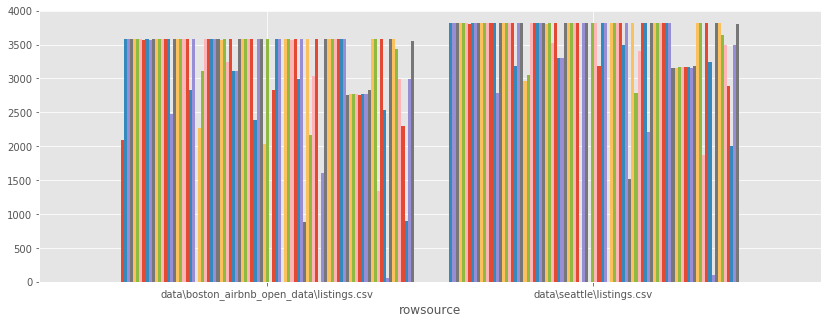

In [11]:
listings\
    .groupby('rowsource')\
    .count()\
    .plot.bar(legend=False, figsize=(14, 5), rot=0, width=.9);

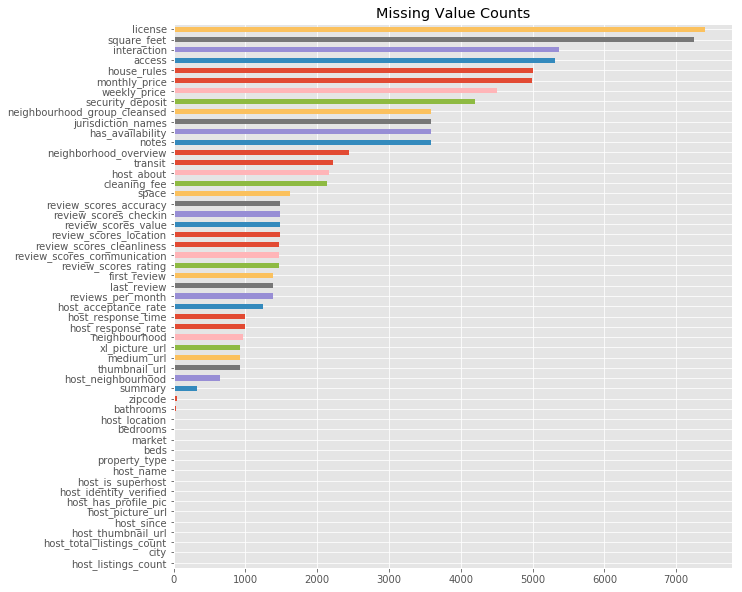

In [12]:
listing_nulls = listings.isnull().sum()\
    .where(lambda x: x>0)\
    .dropna()\
    .sort_values(ascending=True)

listing_nulls\
    .plot.barh(figsize=(10, 10), title="Missing Value Counts");

In [13]:
listings.shape

(7403, 96)

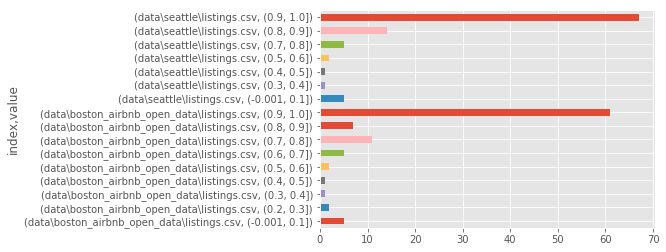

In [14]:
non_complete_listings = listings.groupby('rowsource')\
    .count()\
    .div(listings.rowsource.value_counts(), axis=0)\
    .reset_index()\
    .melt(id_vars='index')

non_complete_listings\
    .groupby(['index', pd.cut(non_complete_listings.value, bins=10)])\
    .size()\
    .plot.barh();

---
Third, we are importing the reviews dataset.

In [15]:
reviews = read_concat(folder_names, 'reviews.csv')

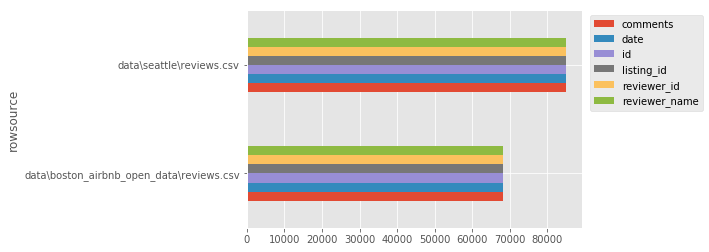

In [16]:
reviews.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');

**Data Import Findings:**
* It is clear that calendar has missing prices.
* It is clear that there are multiple columns with missing values on both datasets.
* On the contrary, reviews are all complete.

## Data Handling: Data Understanding

### <li> Data Understanding: Calendar

In [17]:
# calendar first 5 lines
calendar.head()

,available,date,listing_id,price,rowsource
0,f,2017-09-05,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
1,f,2017-09-04,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
2,f,2017-09-03,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
3,f,2017-09-02,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
4,f,2017-09-01,12147973,NaN,data\boston_airbnb_open_data\calendar.csv


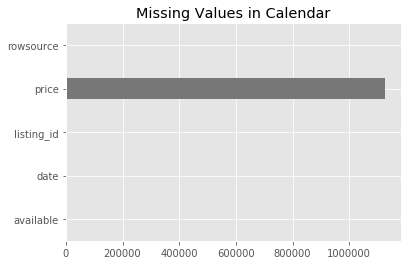

In [18]:
calendar.isnull().sum().plot.barh(title="Missing Values in Calendar");

#### Calendar: Available Feature

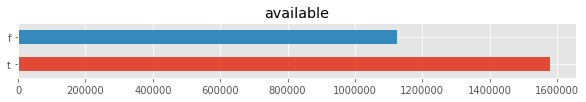

In [19]:
calendar.available.value_counts().plot.barh(figsize=(10, 1), title='available');

#### Calendar: Price Feature

In [20]:
calendar.price.unique()

array([nan, '$65.00', '$75.00', ..., '$10.00', '$24.00', '$817.00'],
      dtype=object)

In [21]:
# Data conversions
calendar.price = calendar.price.str.replace('$', '')
calendar.price = calendar.price.str.replace(',', '').astype(float)
calendar.date = pd.to_datetime(calendar.date)

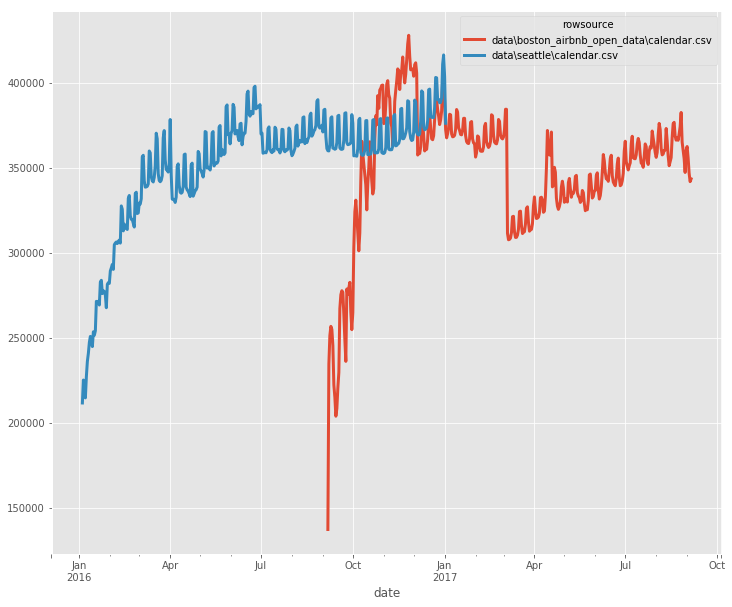

In [22]:
calendar.groupby(['rowsource', 'date'])\
    .agg({'price':'sum'})\
    .reset_index()\
    .pivot(index='date', columns='rowsource', values='price')\
    .plot.line(figsize=(12, 10), lw=3);

In [23]:
calendar['nan_grp'] = calendar.price.fillna('MissingValue')

In [24]:
calendar.loc[calendar.nan_grp!='MissingValue', 'nan_grp'] = 'ProvidedValue'

In [25]:
calendar['source_grp'] = calendar.rowsource.str.cat(calendar.nan_grp, sep=' - ')

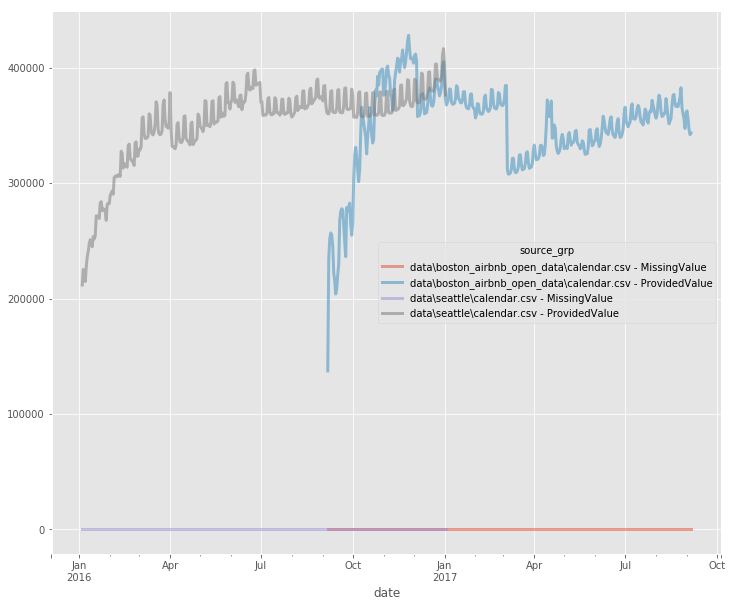

In [26]:
calendar.groupby(['source_grp', 'date'])\
    .agg({'price':'sum'})\
    .reset_index()\
    .pivot(index='date', columns='source_grp', values='price')\
    .plot.line(figsize=(12, 10), lw=3, alpha=.5);

In [27]:
calendar.groupby('source_grp').agg({'date': ['min', 'max']})

date           
                                                          min        max
source_grp                                                              
data\boston_airbnb_open_data\calendar.csv - Mis... 2016-09-06 2017-09-05
data\boston_airbnb_open_data\calendar.csv - Pro... 2016-09-06 2017-09-05
data\seattle\calendar.csv - MissingValue           2016-01-04 2017-01-02
data\seattle\calendar.csv - ProvidedValue          2016-01-04 2017-01-02

In [28]:
month_func = lambda x: x.month
delta_month_func = lambda x: x.max_date.shift(1).apply(month_func)- x.max_date.apply(month_func)
delta_days_func = lambda x: x.max_date.shift(1)- x.max_date

calendar.groupby('rowsource').agg({'date': 'max'})\
    .rename(columns={'date':'max_date'})\
    .assign(delta_month=delta_month_func,
            delta_days=delta_days_func)\
    .fillna('')

,max_date,delta_month,delta_days
rowsource,,,
data\boston_airbnb_open_data\calendar.csv,2017-09-05,,
data\seattle\calendar.csv,2017-01-02,8,246 days 00:00:00


**Calendar Data Findings:**

Informational:
* Records of availability and price at a date and listing id level.
* Only missing values are in prices. Some listings have no prices.
* Dates of datasets do not match.
    * It seems that seattle was service before boston.
    * Seattle has no data from 2017-01-02 to 2017-09-05, 8 months or 246 days.
Transformation:
* Prices have to be cleaned. They include $ sign and comma separators.

### <li> Data Understanding: Listings

In [29]:
missing_pct = listings.isnull().sum()/listings.shape[0]

#### Listings: Object Features

In [30]:
# listings first 5 lines
pd.options.display.max_rows = 100
listings.select_dtypes(include=object).dropna(axis=0, how='all').sample(2).T\
    .merge(missing_pct.to_frame('missing'), left_index=True, right_index=True, how='left')\
    .iloc[:, [2,0,1]].sort_values('missing', ascending=False).style.bar()

,missing,4590,5271
interaction,0.725652,nan,nan
access,0.716872,nan,nan
house_rules,0.676753,nan,nan
monthly_price,0.675132,nan,nan
weekly_price,0.608132,nan,nan
security_deposit,0.566662,nan,nan
jurisdiction_names,0.484263,WASHINGTON,WASHINGTON
neighbourhood_group_cleansed,0.484263,Central Area,Downtown
has_availability,0.484263,t,t
notes,0.483723,nan,nan


#### Listings: Non-Object Features

In [31]:
listings.filter(regex='id')
listings.select_dtypes(exclude=object).sample(4).T\
    .merge(missing_pct.to_frame('missing'), left_index=True, right_index=True, how='left')\
    .iloc[:, [-1, 0, 1, 2, 3]]\
    .sort_values('missing', ascending=False)\
    .style.format("{:2,.2f}").bar(subset=['missing'])

,missing,1695,4566,3441,2710
license,1.00,nan,nan,nan,nan
square_feet,0.98,nan,nan,nan,nan
review_scores_accuracy,0.20,9.00,10.00,nan,9.00
review_scores_checkin,0.20,8.00,10.00,nan,10.00
review_scores_value,0.20,8.00,10.00,nan,9.00
review_scores_location,0.20,9.00,10.00,nan,9.00
review_scores_cleanliness,0.20,8.00,10.00,nan,9.00
review_scores_communication,0.20,9.00,10.00,nan,10.00
review_scores_rating,0.20,83.00,100.00,nan,91.00
reviews_per_month,0.19,0.35,2.83,nan,0.61


### <li> Data Understanding: Reviews

In [32]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


### <li> Data Understanding: Id Relationships

In [33]:
len_func = lambda x: x.str.len()

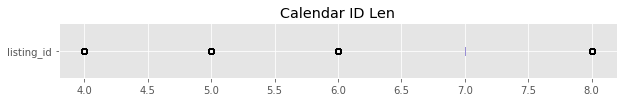

In [34]:
calendar.listing_id.astype(str).str.len()\
    .plot.box(vert=False, figsize=(10, 1), title="Calendar ID Len");

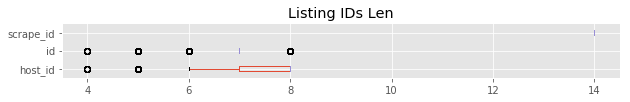

In [35]:
listings.filter(regex='id').select_dtypes(exclude=object).astype(str).apply(len_func)\
    .plot.box(vert=False, figsize=(10, 1), title="Listing IDs Len");

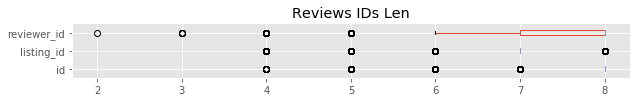

In [36]:
reviews.filter(regex='id').apply(lambda x: x.astype(str).str.len())\
    .plot.box(vert=False, figsize=(10, 1), title="Reviews IDs Len");

**Id Relationships Findings**
* The listing dataset id is the primary key that relates to the listing_id of the calendar dataset.
* The scrape_id does not relate to anything in the downloaded dataset, so therefore si irrelevant for the analysis.
* The host_id in the listing dataset seems to be related to the reviewer_d of the reviews dataset.
* Given that there are reviewer-ids with length of 2 and 3 in the reviwers dataset and not in the listings dataset, we can assume that the listings don't inlcude stays (missing records) for those host with 2 and 3 lenght-ids, but those host have reviews for the listings in the reviewer dataset.

### <li> Data Understanding: Granularity of Datasets

#### Calendar Granularity

In [37]:
duplicates = calendar.groupby(['date', 'listing_id', 'rowsource', 'available'])\
    .size().to_frame('duplicates').query("duplicates>1").head()

In [38]:
calendar_price_dups = duplicates.reset_index().listing_id.unique()[0]
print(f"These are the id of price duplicates: \n {calendar_price_dups}")

These are the id of price duplicates: 
 12898806


##### <ol> Examples of Calendar Duplicates

In [39]:
filter_cond = (calendar.listing_id == 12898806)
calendar.loc[filter_cond, :].sort_values(['date', 'listing_id']).head()

,available,date,listing_id,price,rowsource,nan_grp,source_grp
748850,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748873,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748849,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748872,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748848,t,2016-09-08,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...


> Duplicates on one listing_id.

#### Listing Granularity

In [40]:
listings.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

,duplicates
id,


In [41]:
listings.select_dtypes(include=object)\
    .apply(pd.to_datetime, errors='ignore')\
    .select_dtypes(include=np.datetime64).head()

,calendar_last_scraped,first_review,host_since,last_review,last_scraped
0,2016-09-06,NaT,2015-04-15,NaT,2016-09-07
1,2016-09-06,2014-06-01,2012-06-07,2016-08-13,2016-09-07
2,2016-09-06,2009-07-19,2009-05-11,2016-08-05,2016-09-07
3,2016-09-06,2016-08-28,2013-04-21,2016-08-28,2016-09-07
4,2016-09-06,2015-08-18,2014-05-11,2016-09-01,2016-09-07


> No duplicates. Granulated by listing. Aggregated dates (first, last, since).

#### Reviews Granularity

In [42]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


In [43]:
reviews_duplicated = reviews\
    .groupby(['listing_id', 'reviewer_id', 'date'])\
    .size()\
    .to_frame("duplicates")\
    .query("duplicates>1")\
    .reset_index()
reviews_duplicated.style.bar(subset=['duplicates'])

,listing_id,reviewer_id,date,duplicates
0,447523,35607120,2015-07-06,2
1,568234,16199611,2014-09-08,2
2,1173306,8492099,2013-09-06,2
3,1529321,30877683,2015-05-15,2
4,3533224,39668556,2015-12-01,2
5,3866526,63239764,2016-03-18,2
6,3897963,47193495,2016-04-07,2
7,3897995,39441871,2016-03-23,2
8,3901439,9618964,2016-03-24,2
9,4402209,63239764,2016-03-25,2


##### <ol> Examples of Reviews Duplicates

In [44]:
reviews.merge(reviews_duplicated.drop('duplicates', axis=1),
              on=['listing_id', 'reviewer_id', 'date'], 
              how='left',
              indicator=True)\
    .query("_merge=='both'").head(6)\
    .style.background_gradient(subset=['reviewer_id'])

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource,_merge
6558,Nice neighborhood with a lot of local life and restaurants. Check in was simple and I was never bothered.,2015-05-15,32216803,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
6559,"A+ treatment all the way, you are an adult in a friendly part of town. Nice room and choice of two bathrooms.",2015-05-15,32223055,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
29370,The reservation was canceled 23 days before arrival. This is an automated posting.,2014-09-08,19256952,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
29371,The reservation was canceled 24 days before arrival. This is an automated posting.,2014-09-08,19256954,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
30826,My night at Aris house was perfect yet again! Thank you so much for hosting me Ari!!,2016-03-25,66858887,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both
30827,"The hosts communication was great, the listing was exactly as described definitely stay at Aris house if you need a place in Boston.",2016-03-25,66963792,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both


> Granulated at the listing_id, reviewer_id, and date level. Some duplicates by automation. Some manual duplicates by reviewer with different commets for same date and listing.

**Granularity Findings**
* The calendar dataset is granulated at the date, listing_id level.
    * This dataset has duplicates for listing_id 12898806.
* The listings dataset is granulated at the id level.
    * No duplicates.
* The reviews dataset is granulated at the date, listing_id, reviewer_id level.
    * This dataset has some meaningful duplicates made by the reviewer and some automated duplicates.

### <li> Data Understanding: Testing Relationships

#### Relationship Between Null Prices at calendar_last_scraped

In [45]:
listing_sample = calendar[~calendar.price.isna()].sample(200).listing_id.unique()[:100]
print(f"Sampled {len(listing_sample)} listing ids.")

Sampled 100 listing ids.


In [46]:
calendar_sample = calendar.query(f"listing_id == {list(listing_sample)}")

In [47]:
airbnb_evaluation = calendar_sample.merge(listings,
                      left_on='listing_id',
                      right_on='id',
                      how='inner',
                      suffixes=['', '_last'])
airbnb_evaluation.calendar_last_scraped = pd.to_datetime(airbnb_evaluation.calendar_last_scraped)

In [48]:
listings.columns[listings.columns.str.contains('last')]

Index(['calendar_last_scraped', 'last_review', 'last_scraped'], dtype='object')

In [49]:
# attempting to create relationship between null prices price at calendar_last_scraped
airbnb_evaluation[['listing_id', 'price', 'price_last', 'date', 'calendar_last_scraped']]\
    .query("date==calendar_last_scraped").head()

,listing_id,price,price_last,date,calendar_last_scraped
364,8473851,NaN,$50.00,2016-09-06,2016-09-06
729,12806707,NaN,$60.00,2016-09-06,2016-09-06
1094,728238,NaN,$60.00,2016-09-06,2016-09-06
1459,4538423,NaN,$37.00,2016-09-06,2016-09-06
1824,1373520,NaN,$125.00,2016-09-06,2016-09-06


> **Findings**: No relationship. We cannot inputate using this method.

#### Testing Merge with rowsource and Geographical Columns

In [50]:
geo_columns = list(airbnb_evaluation\
                    .select_dtypes(include=object)\
                    .columns[-10:][:-6]\
                    .drop(['space', 'street']))+['rowsource']

In [51]:
airbnb_evaluation[geo_columns].groupby(geo_columns).size()

smart_location     state  rowsource                                
Boston, MA         MA     data\boston_airbnb_open_data\calendar.csv    12410
Jamaica Plain, MA  MA     data\boston_airbnb_open_data\calendar.csv      365
Seattle, WA        WA     data\seattle\calendar.csv                    23725
dtype: int64

> **Findings**: Merging was succesful at the listing_id and id level. We still have to check the integrity of the data on mergin. Were there duplicates introduced?

#### Looking for Meaningful Relationship Between Listing and Reivews

In [52]:
airbnb_evaluation.filter(regex='revi|id').head()

,listing_id,first_review,host_id,host_identity_verified,id,last_review,number_of_reviews,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,scrape_id
0,8473851,2015-10-02,44625108,t,8473851,2016-08-14,14,10.0,10.0,10.0,10.0,9.0,99.0,10.0,1.23,20160906204935
1,8473851,2015-10-02,44625108,t,8473851,2016-08-14,14,10.0,10.0,10.0,10.0,9.0,99.0,10.0,1.23,20160906204935
2,8473851,2015-10-02,44625108,t,8473851,2016-08-14,14,10.0,10.0,10.0,10.0,9.0,99.0,10.0,1.23,20160906204935
3,8473851,2015-10-02,44625108,t,8473851,2016-08-14,14,10.0,10.0,10.0,10.0,9.0,99.0,10.0,1.23,20160906204935
4,8473851,2015-10-02,44625108,t,8473851,2016-08-14,14,10.0,10.0,10.0,10.0,9.0,99.0,10.0,1.23,20160906204935


In [53]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


> **Findings**: There was no meaninful relationship related to the business questions. The listings already have ratings in it. Therefore, I don't see the need for sentiment analysis here.  Thus, this dataset will be ingored for the rest of the analysis.

## Data Handling: Preparing Data for Analysis

In [54]:
# column additions fro scatter and monthly comparisons
calendar['date_num'] = calendar.date.rank(method='dense')
calendar['month_name'] = calendar.date.apply(lambda x: x.month_name())
max_date = str(calendar.date.max().date())
min_date = str(calendar.date.min().date())

### <li> Preparing Data for Analysis: Calendar Null Analysis

#### Nan Price Removal Impact

In [55]:
calendar.groupby('nan_grp').size().to_frame('row_count')\
        .assign(pct_total=lambda x: x.row_count/x.row_count.sum()*100)

,row_count,pct_total
nan_grp,,
MissingValue,1124881,41.624335
ProvidedValue,1577579,58.375665


In [56]:
def null_bar_by(column):
    calendar.groupby([column, 'nan_grp']).size().to_frame('row_count')\
        .assign(pct_total=lambda x: x.row_count/x.row_count.sum()*100)\
        .reset_index().query("nan_grp=='MissingValue'")\
        .plot.barh(x=column, y='pct_total', 
                   legend=False, figsize=(10, 4),
                   title=f"Missing Prices from {min_date} to {max_date}");
    plt.xlabel('% Missing Prices of Grand Total');

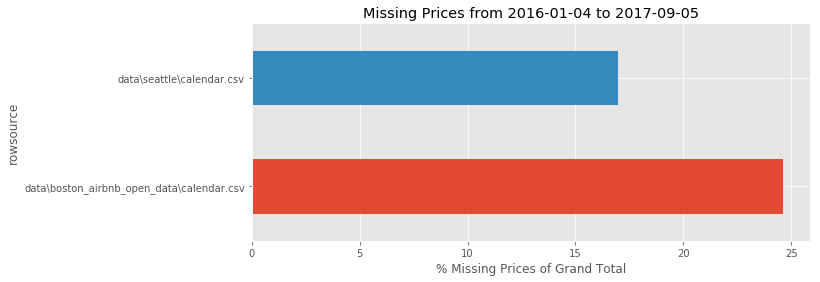

In [57]:
null_bar_by('rowsource')

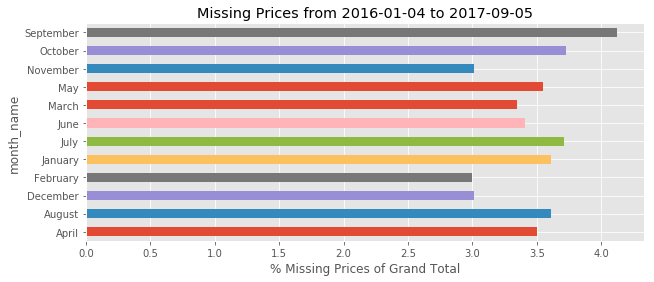

In [58]:
null_bar_by('month_name')

In [59]:
calendar_price_bymonth = calendar.reset_index(drop=True)\
    .pivot(columns='month_name', values='price')

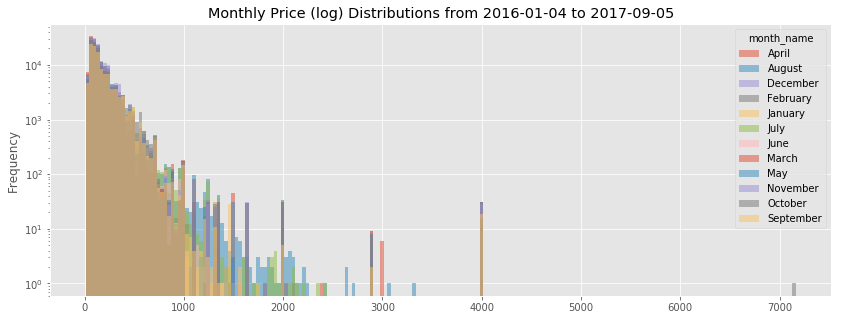

In [60]:
calendar_price_bymonth\
    .plot.hist(bins=200, 
               figsize=(14, 5), 
               logy=True,
               alpha=.5,
               title=f'Monthly Price (log) Distributions from {min_date} to {max_date}');

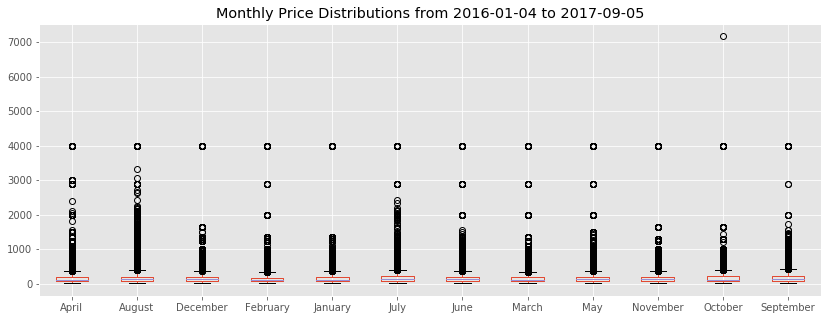

In [61]:
calendar_price_bymonth\
    .plot.box(figsize=(14, 5),
              title=f'Monthly Price Distributions from {min_date} to {max_date}');

In [62]:
calendar_price_bysource = calendar.reset_index(drop=True)\
    .pivot(columns='rowsource', values='price')

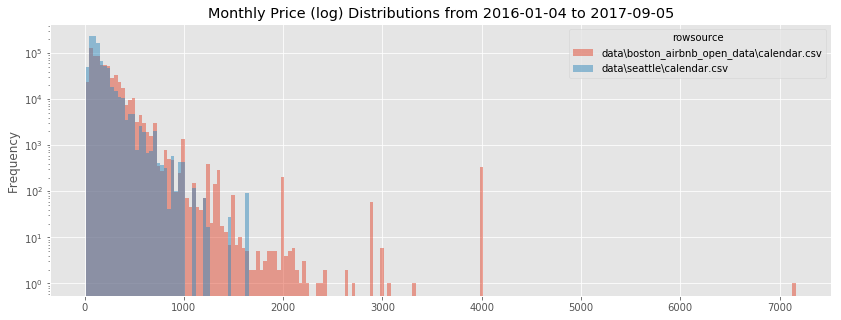

In [63]:
calendar_price_bysource\
    .plot.hist(bins=200, 
               figsize=(14, 5), 
               logy=True,
               alpha=.5,
               title=f'Monthly Price (log) Distributions from {min_date} to {max_date}');

KeyboardInterrupt: 

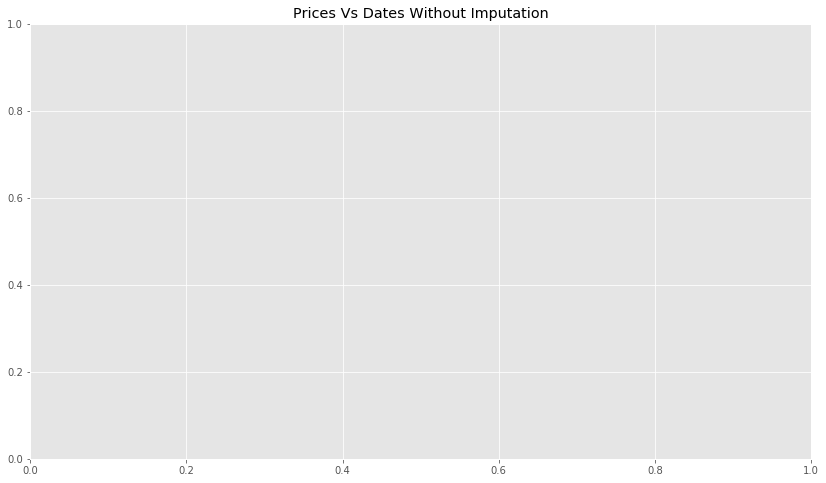

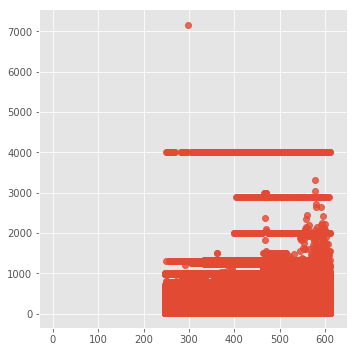

In [66]:
plt.figure(figsize=(14, 8));
plt.title('Prices Vs Dates Without Imputation')
sns.lmplot(x='date_num', 
                y='price', 
                hue='rowsource', 
                data=calendar);

> **Price Imputation Decision**: 
* Given that the prices are skew to the left, the imputation approach will be the median method on a daily basis, which is not influenced by outliers.
* Given that we were going to remove 42% of the data because of Null prices, I am attempting to mitigate the loss of information by imputing the median on a daily basis, but I am leaving a category for those values that were imputated for the model to recognize those. Perhaps it will be beneficial.
* Another idea is to pass a test set that was not imputated to see if the imputation caused overfitting. I will be able to know what was imputated by looking at the imputed_price column.

### <li> Preparing Data for Analysis: Listings Null Analysis

#### Listings Columns With Nulls

In [67]:
# recalling columns with nulls from previous null analysis
listing_null_columns = list(listing_nulls.index.drop('license'))
print(listing_null_columns)

['host_listings_count', 'city', 'host_total_listings_count', 'host_thumbnail_url', 'host_since', 'host_picture_url', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_name', 'property_type', 'beds', 'market', 'bedrooms', 'host_location', 'bathrooms', 'zipcode', 'summary', 'host_neighbourhood', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'neighbourhood', 'host_response_rate', 'host_response_time', 'host_acceptance_rate', 'reviews_per_month', 'last_review', 'first_review', 'review_scores_rating', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 'review_scores_checkin', 'review_scores_accuracy', 'space', 'cleaning_fee', 'host_about', 'transit', 'neighborhood_overview', 'notes', 'has_availability', 'jurisdiction_names', 'neighbourhood_group_cleansed', 'security_deposit', 'weekly_price', 'monthly_price', 'house_rules', 'access', 'interaction', 'square_feet']


#### Dropping Listings Columns With all Nulls

In [68]:
listings.dropna(how='all', axis=1, inplace=True)

#### Listings Null Analysis

In [69]:
t_columns = listings.shape[1]
h_columns = listings.isnull().sum(axis=1)
listings.loc[:, 'row_null_pct'] = h_columns/t_columns

In [70]:
def listing_dist(df, bins, title):
    upper_func = lambda x: x.state.str.upper()
    df.assign(state=upper_func)[['state', 'row_null_pct']]\
        .reset_index()\
        .pivot(index='index',
              columns='state',
              values='row_null_pct')\
        .plot.hist(alpha=.5, 
                   bins=bins,
                   figsize=(12, 5),
                   title=title);

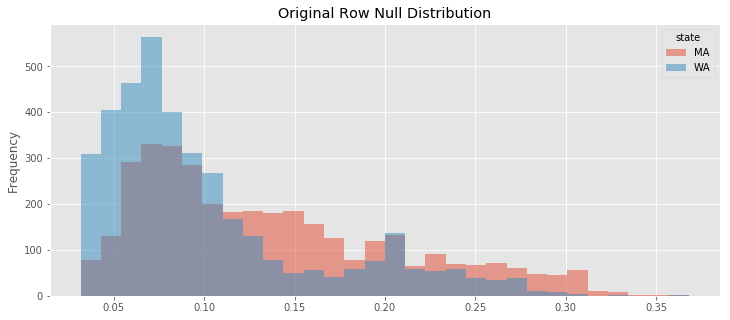

In [71]:
listing_dist(listings, 30, 'Original Row Null Distribution')               

> **Row Null Removal Decision**:
  * Will remove any row that contains more than 30 % of null values
  * Will attempt to imputate anything with less than 30 % of null values
  * What we cannot imputate will be feeded to the model as null dummies

#### Removal of Listing Records

In [72]:
# removal threshold
row_remove = listings.row_null_pct <= .30

# removing rows
listings_row_clean = listings[row_remove]

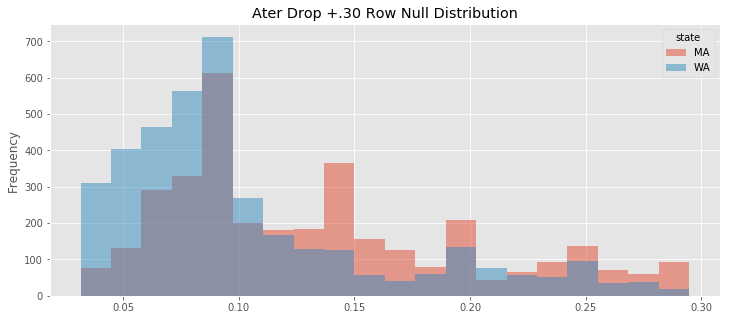

In [73]:
listing_dist(listings_row_clean, 20, 'Ater Drop +.30 Row Null Distribution')

> **Row Null Removal Results**
* The distribution of null still looks skew. But it is better than before.
* The next step is imputations of null values to see if we can make this distribution look more normal.

#### Imputation of Listing Records

In [74]:
listings_row_clean.isnull().sum().where(lambda x: x>0).dropna().index.tolist()

['access',
 'bathrooms',
 'bedrooms',
 'beds',
 'city',
 'cleaning_fee',
 'first_review',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_location',
 'host_neighbourhood',
 'host_response_rate',
 'host_response_time',
 'house_rules',
 'interaction',
 'jurisdiction_names',
 'last_review',
 'market',
 'medium_url',
 'monthly_price',
 'neighborhood_overview',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'notes',
 'property_type',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'security_deposit',
 'space',
 'square_feet',
 'summary',
 'thumbnail_url',
 'transit',
 'weekly_price',
 'xl_picture_url',
 'zipcode']

##### <ol> Investigating Access

In [75]:
listings_row_clean[['access']].head(10)

,access
0,"You will have access to 2 bedrooms, a living r..."
1,Apt has one more bedroom (which I use) and lar...
2,"I am living in the apartment during your stay,..."
3,The basement has a washer dryer and gym area. ...
4,You will have access to the front and side por...
5,Guests are welcome to share our living room an...
6,I have an electronic keypad so arrival time ca...
7,Amenities include an evening snack upon arriva...
8,NaN
9,NaN


#####  <ol> Converting Access to AccessInfoProvided

In [77]:
# creating the new column for provided access information
listings_row_clean.loc[:, 'AccessInfoProvided'] = listings_row_clean.access\
    .where(lambda x: x.isnull(), 1).fillna(0)

# dropping the source of the new column
listings_row_clean.drop('access', axis=1, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'access'

##### <ol> Investigating Bathrooms

In [101]:
bathroom_to_impute = listings_row_clean.groupby('bedrooms').bathrooms
bathroom_to_impute = bathroom_to_impute.apply(lambda x: x.mode()).to_frame()
bathroom_to_impute

bathrooms
bedrooms             
0.0      0        1.0
1.0      0        1.0
2.0      0        1.0
3.0      0        2.0
4.0      0        2.0
5.0      0        3.5
6.0      0        3.0
         1        3.5
7.0      0        4.0

In [84]:
listings_row_clean.groupby(['bedrooms']).bathrooms.transform('median').unique()

array([1.  , 2.  , 2.5 , 3.  ,  nan, 3.25, 4.  ])

In [92]:
listings_row_clean.groupby(['bedrooms', 'bathrooms']).size().to_frame('listings')

listings
bedrooms bathrooms          
0.0      0.0               3
         0.5               3
         1.0             641
         1.5               4
         3.5               1
1.0      0.0              18
         0.5              35
         1.0            4072
         1.5             277
         2.0             211
         2.5              44
         3.0              19
         3.5              15
         4.5               1
         5.0               6
         6.0               4
         8.0               2
2.0      1.0             719
         1.5             109
         2.0             439
         2.5              51
         3.0               3
         5.0               1
3.0      1.0              98
         1.5              53
         2.0             153
         2.5              77
         3.0              32
         3.5              19
         4.0               2
4.0      1.0              11
         1.5               7
         2.0              35
         2.5              16
         3.0              21
         3.5              20
         4.0               4
5.0      1.0               2
         1.5               3
         2.0               7
         2.5               3
         3.0               7
         3.5              13
         4.0               2
         4.5               3
6.0      2.0               1
         3.0               2
         3.5               2
         4.0               1
7.0      4.0               1

### <li> Preparing Data for Analysis: Starting Calendar Imputations

In [64]:
calendar_imputed = calendar.copy()

#### Null Price Imputations

In [65]:
filter_bos_cond = (calendar.rowsource == 'data\\boston_airbnb_open_data\\calendar.csv')
filter_sea_cond = (calendar.rowsource == 'data\\seattle\\calendar.csv')

##### <ol> Boston Imputation

In [66]:
calendar[filter_bos_cond].query("date == '2017-09-05'").price.describe()

count    1801.000000
mean      190.804553
std       182.108034
min        20.000000
25%        80.000000
50%       150.000000
75%       249.000000
max      4000.000000
Name: price, dtype: float64

In [84]:
# daily medians to impute for boston
bos_medians = calendar[filter_bos_cond].groupby(['rowsource', 'date']).price.transform('median')

# boston price imputation
calendar_imputed.loc[filter_bos_cond, 'price'] = calendar[filter_bos_cond].price.fillna(bos_medians)

In [85]:
# Validating imputation
calendar_imputed.query("date=='2017-09-05' and nan_grp=='MissingValue'").head(1)

,available,date,listing_id,price,rowsource,nan_grp,source_grp,date_num,month_name
0,f,2017-09-05,12147973,150.0,data\boston_airbnb_open_data\calendar.csv,MissingValue,data\boston_airbnb_open_data\calendar.csv - Mi...,611.0,September


##### <ol> Seattle Imputation

In [77]:
calendar[filter_sea_cond].query("date == '2016-09-05'").price.describe()

count    2544.000000
mean      142.087264
std       109.675987
min        20.000000
25%        75.000000
50%       110.000000
75%       170.000000
max      1450.000000
Name: price, dtype: float64

In [86]:
# daily medians to impute for boston
sea_medians = calendar[filter_sea_cond].groupby(['rowsource', 'date']).price.transform('median')

# boston price imputation
calendar_imputed.loc[filter_sea_cond, 'price'] = calendar[filter_sea_cond].price.fillna(sea_medians)

In [87]:
# Validating imputation
calendar_imputed.query("date=='2016-09-05' and nan_grp=='MissingValue'").head(1)

,available,date,listing_id,price,rowsource,nan_grp,source_grp,date_num,month_name
2800,f,2016-09-05,856550,110.0,data\seattle\calendar.csv,MissingValue,data\seattle\calendar.csv - MissingValue,246.0,September


##### <ol> imputed_price Category

In [90]:
# mapping the labels for the imputed_price category
imputed_price = {'MissingValue': 1, 'ProvidedValue': 0}

# creating category
calendar_imputed['imputed_price'] = calendar_imputed.nan_grp.map(imputed_price)

In [95]:
# validating imputed_price category
calendar_imputed.query("imputed_price==1").nan_grp.unique()

array(['MissingValue'], dtype=object)

In [97]:
# dropping nan_grp and other unecessary columns
drop_from_calendar = ['rowsource', 'nan_grp', 'source_grp']
calendar_imputed.drop(drop_from_calendar, axis=1, inplace=True)

In [98]:
calendar_imputed.head()

,available,date,listing_id,price,date_num,month_name,imputed_price
0,f,2017-09-05,12147973,150.0,611.0,September,1
1,f,2017-09-04,12147973,150.0,610.0,September,1
2,f,2017-09-03,12147973,150.0,609.0,September,1
3,f,2017-09-02,12147973,150.0,608.0,September,1
4,f,2017-09-01,12147973,150.0,607.0,September,1


# Analysis & Visualizations

# Modeling & Visualizations

# Evaluating Results

# Conclussion

In [217]:
os.system("git add .")

0

In [218]:
os.system('git commit -m "Understading review and listing relationship"')

0

In [219]:
os.system("git push")

0